In [48]:
import os
import tensorflow as tf
import numpy as np
import scipy.io

content_directory = 'contents/'
style_directory = 'styles/'

# This is the directory to store the final stylized images
output_directory = 'image_output/'
if not os.path.exists(output_directory):
  os.makedirs(output_directory)
    
# This is the directory to store the half-done images during the training.
checkpoint_directory = 'checkpoint_output/'
if not os.path.exists(checkpoint_directory):
  os.makedirs(checkpoint_directory)
    
content_path = os.path.join(content_directory, 'wonder-woman.jpg')
style_path = os.path.join(style_directory, 'starry-night.jpg')
output_path = os.path.join(output_directory, 'wonder-woman-starry-night-iteration-1000.jpg')

# please notice that the checkpoint_images_path has to contain %s in the file_name
checkpoint_path = os.path.join(checkpoint_directory, 'wonder-woman-starry-night-iteration-1000-%s.jpg')

In [74]:
import tensorflow as tf
import numpy as np
import scipy.io
import os

VGG_MEAN = [103.939, 116.779, 123.68]

VGG19_LAYERS = (
  'conv1_1', 'relu1_1', 'conv1_2', 'relu1_2', 'pool1',

  'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'pool2',

  'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 'conv3_3',
  'relu3_3', 'conv3_4', 'relu3_4', 'pool3',

  'conv4_1', 'relu4_1', 'conv4_2', 'relu4_2', 'conv4_3',
  'relu4_3', 'conv4_4', 'relu4_4', 'pool4',

  'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2', 'conv5_3',
'relu5_3', 'conv5_4', 'relu5_4'
)


def net_preloaded(input_image, pooling):
  data_dict = np.load('libs/vgg19.npy', encoding='latin1').item()
  net = {}
  current = input_image
  for i, name in enumerate(VGG19_LAYERS):
    kind = name[:4]
    if kind == 'conv':
      kernels = get_conv_filter(data_dict, name)
      # kernels = np.transpose(kernels, (1, 0, 2, 3))

      bias = get_bias(data_dict, name)
      # matconvnet: weights are [width, height, in_channels, out_channels]
      # tensorflow: weights are [height, width, in_channels, out_channels]

      # bias = bias.reshape(-1)
      current = conv_layer(current, kernels, bias)
    elif kind == 'relu':
      current = tf.nn.relu(current)
    elif kind == 'pool':
      current = pool_layer(current, pooling)
    
    net[name] = current

  assert len(net) == len(VGG19_LAYERS)
  return net

def conv_layer(input, weights, bias):
  conv = tf.nn.conv2d(input, weights, strides=(1, 1, 1, 1), padding='SAME')
  return tf.nn.bias_add(conv, bias)


def pool_layer(input, pooling):
  if pooling == 'avg':
    return tf.nn.avg_pool(input, ksize=(1, 2, 2, 1), strides=(1, 2, 2, 1),
            padding='SAME')
  else:
    return tf.nn.max_pool(input, ksize=(1, 2, 2, 1), strides=(1, 2, 2, 1),
            padding='SAME')

# before we feed the image into the network, we preprocess it by 
# extracting the mean_pixel from it.
def preprocess(image):
  return image - VGG_MEAN

# remember to unprocess it before you plot it out and save it.
def unprocess(image):
  return image + VGG_MEAN

def get_conv_filter(data_dict, name):
  return tf.constant(data_dict[name][0], name="filter")

def get_bias(data_dict, name):
  return tf.constant(data_dict[name][1], name="biases")

In [76]:
import tensorflow as tf
import numpy as np
from functools import reduce
from PIL import Image

# feel free to try different layers
CONTENT_LAYERS = ('relu4_3', 'relu5_3')
STYLE_LAYERS = ('relu1_2', 'relu2_2', 'relu3_2', 'relu4_2', 'relu5_2')

VGG_MEAN = [103.939, 116.779, 123.68]

def stylize(content, styles, network_path='libs/imagenet-vgg-verydeep-19.mat', 
            iterations=1000, content_weight=5e0, content_weight_blend=0.5, style_weight=5e2, 
            style_layer_weight_exp=1,style_blend_weights=None, tv_weight=100,
            learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-08, pooling='avg',
            print_iterations=100, checkpoint_iterations=100, checkpoint_path=None,
            output_path=None):
    
    
  shape = (1,) + content.shape                             #content image shape : (1,433,770,3)
  style_shapes = [(1,) + style.shape for style in styles]  #style image shape : (1,600,800,3)
  content_features = {}
  style_features = [{} for _ in styles]

    
  # scale the importance of each style layers according to their depth. 
  # (deeper layers are more important if style_layers_weights > 1 (default = 1))
  layer_weight = 1.0
  style_layers_weights = {}                                # weight for different network layers
  for style_layer in STYLE_LAYERS:                                    
    style_layers_weights[style_layer] = layer_weight       #'relu1_1','relu2_1',...,'relu5_1'
    layer_weight *= style_layer_weight_exp                 # 1.0

        
  # normalize style layer weights
  layer_weights_sum = 0
  for style_layer in STYLE_LAYERS:                         #'relu1_1',..., 'relu5_1'
    layer_weights_sum += style_layers_weights[style_layer] # 5.0
  for style_layer in STYLE_LAYERS:
    style_layers_weights[style_layer] /= layer_weights_sum

        
  # FEATURE MAPS FROM CONTENT IMAGE
  # compute the feature map of the content image by feeding it into the network
  #the output net contains the features of each content layer
  g = tf.Graph()
  with g.as_default(), tf.Session() as sess:
    image = tf.placeholder('float', shape=shape)

    net = net_preloaded(image, pooling)             # {'conv1_1':Tensor,relu1_1:Tensor...}
    content_pre = np.array([preprocess(content)])   # (1,433,770,3) subtract the mean pixel
    for layer in CONTENT_LAYERS:                    #'relu4_2', 'relu5_2'
      content_features[layer] = net[layer].eval(feed_dict={image: content_pre})  

            
  # FEATURE MAPS (GRAM MATRICES) FROM STYLE IMAGE
  # compute style features of the style image by feeding it into the network
  # and calculate the gram matrix
  for i in range(len(styles)):
    g = tf.Graph()
    with g.as_default(), tf.Session() as sess:
      image = tf.placeholder('float', shape=style_shapes[i])
      net = net_preloaded(image, pooling)                           
      style_pre = np.array([preprocess(styles[i])])
      for layer in STYLE_LAYERS:              #'relu1_1', 'relu2_1',..., 'relu5_1'
        features = net[layer].eval(feed_dict={image: style_pre})  # relu_1:(1,600,800,64)
        features = np.reshape(features, (-1, features.shape[3]))  # (480000, 64)
        gram = np.matmul(features.T, features) / features.size    # (64,64)
        style_features[i][layer] = gram

                
  # make stylized image using backpropogation
  with tf.Graph().as_default():

    # Generate a random image (the output image) with the same shape as the content image
    initial = tf.random_normal(shape) * 0.256  
    image = tf.Variable(initial)
    net = net_preloaded(image, pooling)
    

    # CONTENT LOSS
    # we can adjust the weight of each content layers
    # content_weight_blend is the ratio of two used content layers in this example
    content_layers_weights = {}
    content_layers_weights['relu4_3'] = content_weight_blend 
    content_layers_weights['relu5_3'] = 1.0 - content_weight_blend      

    content_loss = 0
    content_losses = []
    for content_layer in CONTENT_LAYERS:
      # Use MSE as content losses
      # content weight is the coefficient for content loss
      content_losses.append(content_layers_weights[content_layer] * content_weight * 
              (2 * tf.nn.l2_loss(net[content_layer] - content_features[content_layer]) /
              content_features[content_layer].size))
    content_loss += reduce(tf.add, content_losses)



    # STYLE LOSS
    # We can specify different weight for different style images
    # style_layers_weights => weight for different network layers
    # style_blend_weights => weight between different style images

    if style_blend_weights is None:
      style_blend_weights = [1.0/len(styles) for _ in styles]
    else:
      total_blend_weight = sum(style_blend_weights)
      # normalization
      style_blend_weights = [weight/total_blend_weight
                             for weight in style_blend_weights]


    style_loss = 0
    # iterate to calculate style loss with multiple style images
    for i in range(len(styles)):
      style_losses = []
      for style_layer in STYLE_LAYERS:             # e.g. relu1_1
        layer = net[style_layer]                   # relu1_1 of output image:(1,433,770,64)
        _, height, width, number = map(lambda i: i.value, layer.get_shape())  
        size = height * width * number
        feats = tf.reshape(layer, (-1, number))    # (333410,64)

        # Gram matrix for the features in relu1_1 of the output image.
        gram = tf.matmul(tf.transpose(feats), feats) / size
        # Gram matrix for the features in relu1_1 of the style image
        style_gram = style_features[i][style_layer]   

        # Style loss is the MSE for the difference of the 2 Gram matrices
        style_losses.append(style_layers_weights[style_layer] * 2 * 
                            tf.nn.l2_loss(gram - style_gram) / style_gram.size)
      style_loss += style_weight * style_blend_weights[i] * reduce(tf.add, style_losses)


    # TOTAL VARIATION LOSS  
    # Total variation denoising to do smoothing; cost to penalize neighboring pixel
    # not used by the original paper by Gatys et al
    # According to the paper Mahendran, Aravindh, and Andrea Vedaldi. "Understanding deep 
    # image representations by inverting them."
    # Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition. 2015.
    tv_y_size = _tensor_size(image[:,1:,:,:])
    tv_x_size = _tensor_size(image[:,:,1:,:])
    tv_loss = tv_weight * 2 * (
      (tf.nn.l2_loss(image[:,1:,:,:] - image[:,:shape[1]-1,:,:]) /
          tv_y_size) +
      (tf.nn.l2_loss(image[:,:,1:,:] - image[:,:,:shape[2]-1,:]) /
          tv_x_size))


    #OVERALL LOSS
    loss = content_loss + style_loss + tv_loss

    train_step = tf.train.AdamOptimizer(learning_rate, beta1, beta2, epsilon).minimize(loss)

    def print_progress():
      print('     iteration: %d\n' % i)
      print('  content loss: %g\n' % content_loss.eval())
      print('    style loss: %g\n' % style_loss.eval())
      print('       tv loss: %g\n' % tv_loss.eval())
      print('    total loss: %g\n' % loss.eval())

    def imsave(path, img):
      img = np.clip(img, 0, 255).astype(np.uint8)
      Image.fromarray(img).save(path, quality=95)

    
    
    # TRAINING
    best_loss = float('inf')
    best = None
    
    with tf.Session() as sess:
        
      sess.run(tf.global_variables_initializer())
    
      if (print_iterations and print_iterations != 0):
        print_progress()
        
      for i in range(iterations):

        train_step.run()

        last_step = (i == iterations - 1)
        if last_step or (print_iterations and i % print_iterations == 0):
          print_progress()

        # store output and checkpoint images
        if (checkpoint_iterations and i % checkpoint_iterations == 0) or last_step:
          this_loss = loss.eval()
          if this_loss < best_loss:
            best_loss = this_loss
            best = image.eval()

          img_out = unprocess(best.reshape(shape[1:]))

          output_file = None
          if not last_step:
            if checkpoint_path:
                output_file = checkpoint_path % i
          else:
            output_file = output_path

          if output_file:
            imsave(output_file, img_out)
            
  print("finish stylizing.")



def _tensor_size(tensor):
  from operator import mul
  return reduce(mul, (d.value for d in tensor.get_shape()), 1)

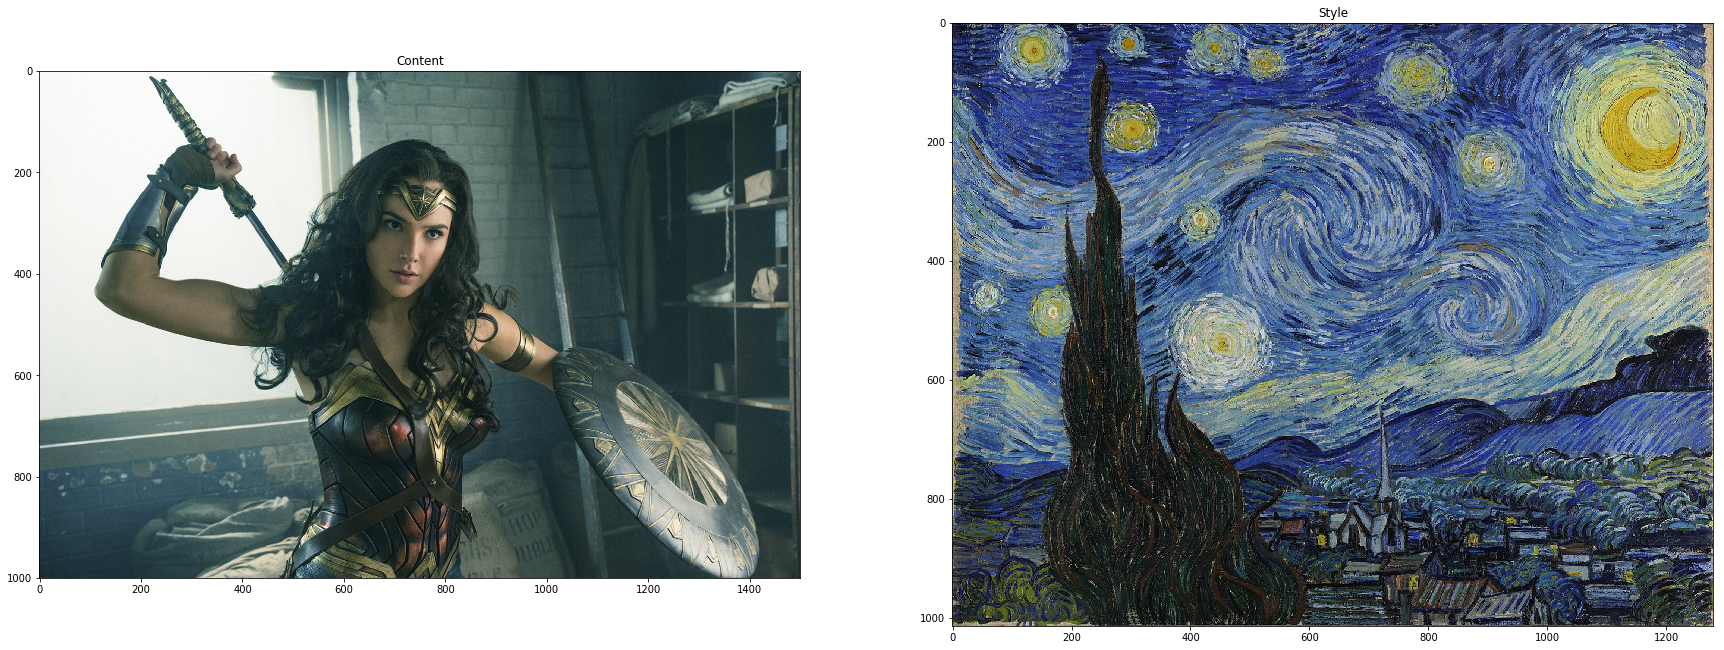

In [52]:
content_image = utils.loadImage(content_directory, 'wonder-woman.jpg')
style_image = utils.loadImage(style_directory, 'starry-night.jpg')
utils.showImage(content_image, style_image)

In [55]:
checkpoint_path=None
output_path = output_directory + 'wonder-woman-starry-night-tvweight-100.jpg'

stylize(content_image, [style_image], iterations=1000,
        content_weight=5e-1, content_weight_blend=1, style_weight=5e2, 
        style_layer_weight_exp=1, style_blend_weights=None, tv_weight=100,
        learning_rate=1e1, beta1=0.9, beta2=0.999, epsilon=1e-08, pooling='avg',
        print_iterations=100, checkpoint_iterations=100, checkpoint_path=checkpoint_path,
        output_path=output_path)

     iteration: 0

  content loss: 22327.4

    style loss: 2.19305e+06

       tv loss: 26.2016

    total loss: 2.2154e+06

     iteration: 0

  content loss: 22429.9

    style loss: 1.86385e+06

       tv loss: 15451.2

    total loss: 1.90173e+06

     iteration: 100

  content loss: 31434.7

    style loss: 16749.6

       tv loss: 44371.2

    total loss: 92555.4

     iteration: 200

  content loss: 25221

    style loss: 12831.3

       tv loss: 40338

    total loss: 78390.3

     iteration: 300

  content loss: 22095.2

    style loss: 10226.2

       tv loss: 37931.4

    total loss: 70252.8

     iteration: 400

  content loss: 21142.1

    style loss: 11168.6

       tv loss: 38326.3

    total loss: 70636.9

     iteration: 500

  content loss: 20549.3

    style loss: 10668.6

       tv loss: 38400

    total loss: 69618

     iteration: 600

  content loss: 19575.2

    style loss: 11537.5

       tv loss: 36544.4

    total loss: 67657.1

     iteration: 700

  conten

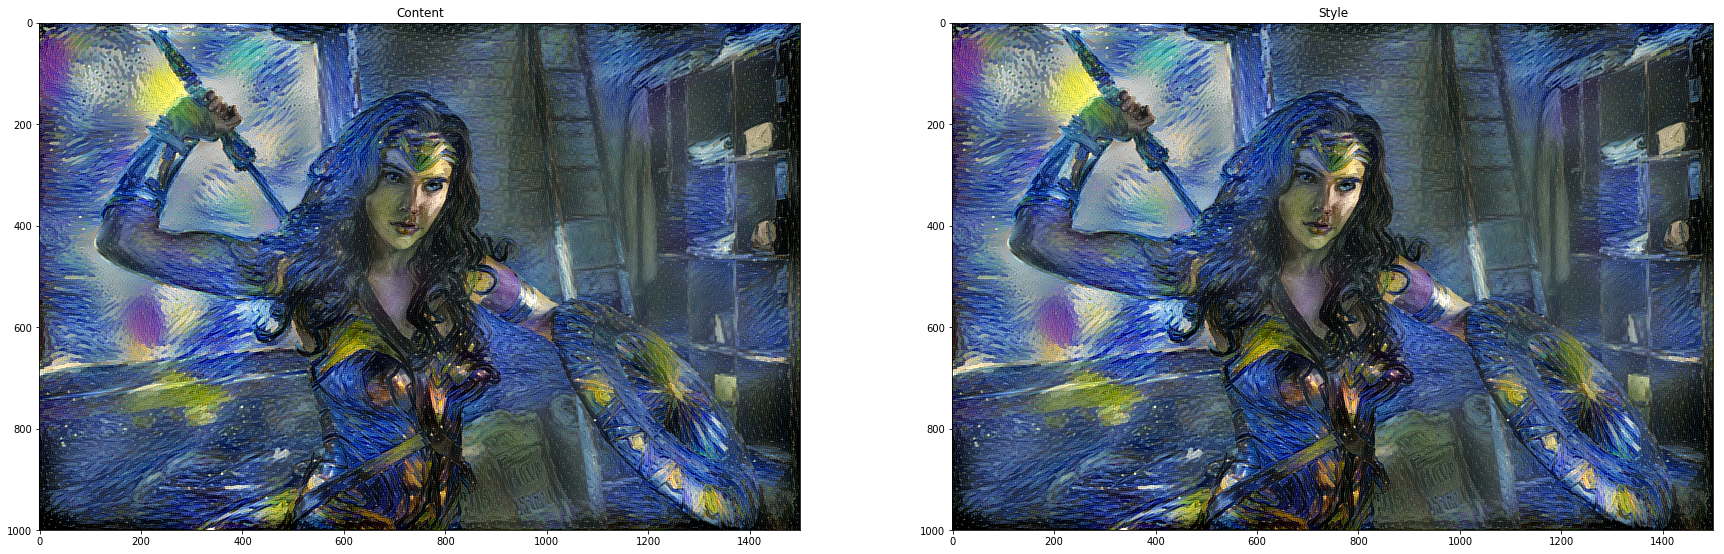

In [58]:
output_image = utils.loadImage(output_directory, 'wonder-woman-starry-night-tvweight-100.jpg')
utils.showImage(output_image, output_image)

將content weight從原本的5e0改成5e-1，可以發現出來的圖片更接近style image，越不像content image原本的樣子

In [59]:
stylize(content_image, [style_image], iterations=1000,
        content_weight=5e2, content_weight_blend=1, style_weight=5e2, 
        style_layer_weight_exp=1, style_blend_weights=None, tv_weight=100,
        learning_rate=1e1, beta1=0.9, beta2=0.999, epsilon=1e-08, pooling='avg',
        print_iterations=100, checkpoint_iterations=100, checkpoint_path=checkpoint_path,
        output_path=output_path)

     iteration: 0

  content loss: 2.2326e+07

    style loss: 2.19305e+06

       tv loss: 26.1935

    total loss: 2.45191e+07

     iteration: 0

  content loss: 2.18103e+07

    style loss: 1.93188e+06

       tv loss: 16372

    total loss: 2.37586e+07

     iteration: 100

  content loss: 2.58583e+06

    style loss: 832935

       tv loss: 148763

    total loss: 3.56752e+06

     iteration: 200

  content loss: 1.79471e+06

    style loss: 818494

       tv loss: 139254

    total loss: 2.75246e+06

     iteration: 300

  content loss: 1.563e+06

    style loss: 822335

       tv loss: 138182

    total loss: 2.52352e+06

     iteration: 400

  content loss: 1.4175e+06

    style loss: 827140

       tv loss: 138333

    total loss: 2.38298e+06

     iteration: 500

  content loss: 1.40654e+06

    style loss: 829138

       tv loss: 139990

    total loss: 2.37567e+06

     iteration: 600

  content loss: 1.32679e+06

    style loss: 837570

       tv loss: 139415

    total l

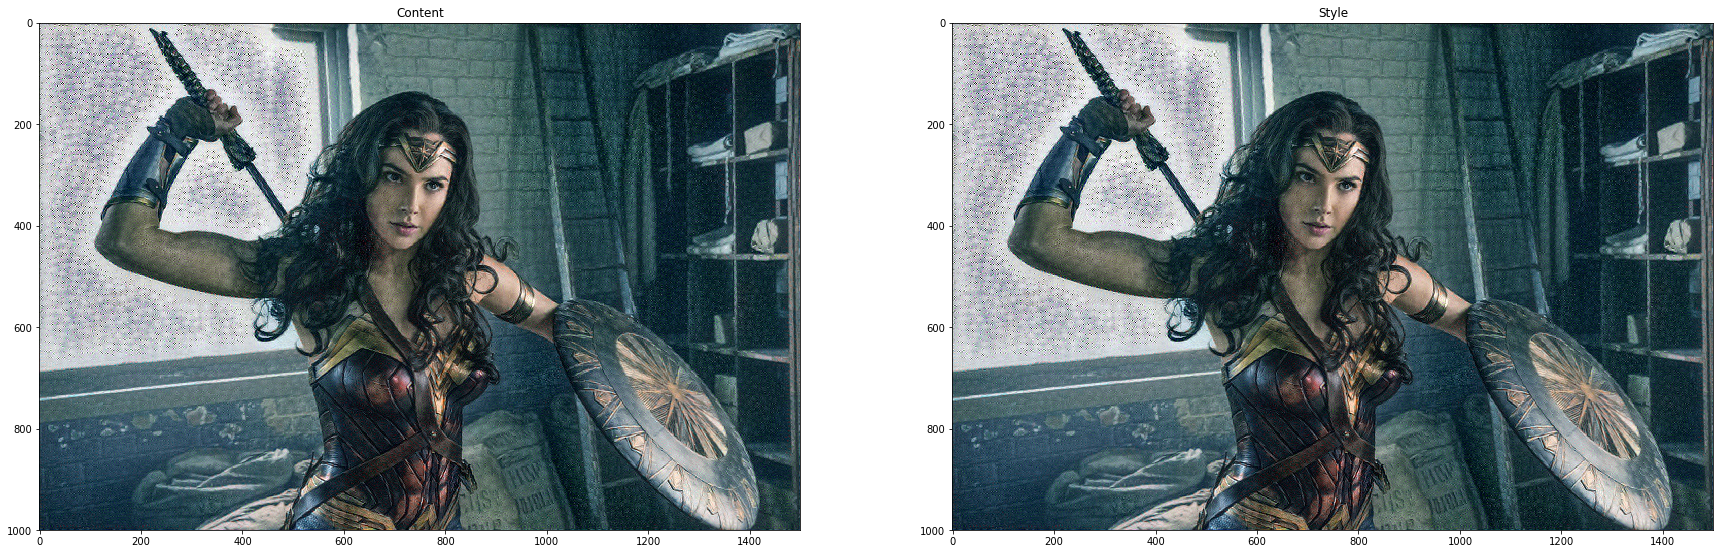

In [60]:
output_image = utils.loadImage(output_directory, 'wonder-woman-starry-night-tvweight-100.jpg')
utils.showImage(output_image, output_image)

把content weight調大之後，發現結果和原圖差不多，只是多了一點油畫的感覺

In [61]:
stylize(content_image, [style_image], iterations=1000,
        content_weight=5e0, content_weight_blend=1, style_weight=5e3, 
        style_layer_weight_exp=1, style_blend_weights=None, tv_weight=100,
        learning_rate=1e1, beta1=0.9, beta2=0.999, epsilon=1e-08, pooling='avg',
        print_iterations=100, checkpoint_iterations=100, checkpoint_path=checkpoint_path,
        output_path=output_path)

     iteration: 0

  content loss: 223280

    style loss: 2.19305e+07

       tv loss: 26.2455

    total loss: 2.21538e+07

     iteration: 0

  content loss: 224398

    style loss: 1.86398e+07

       tv loss: 15509.9

    total loss: 1.88797e+07

     iteration: 100

  content loss: 295772

    style loss: 99036.9

       tv loss: 85629.5

    total loss: 480438

     iteration: 200

  content loss: 228522

    style loss: 73137.5

       tv loss: 70986.6

    total loss: 372646

     iteration: 300

  content loss: 208352

    style loss: 45375.9

       tv loss: 67969.2

    total loss: 321697

     iteration: 400

  content loss: 198260

    style loss: 72811.5

       tv loss: 66681.7

    total loss: 337753

     iteration: 500

  content loss: 191117

    style loss: 37304.1

       tv loss: 67336

    total loss: 295758

     iteration: 600

  content loss: 175927

    style loss: 35759.5

       tv loss: 63168.1

    total loss: 274854

     iteration: 700

  content loss:

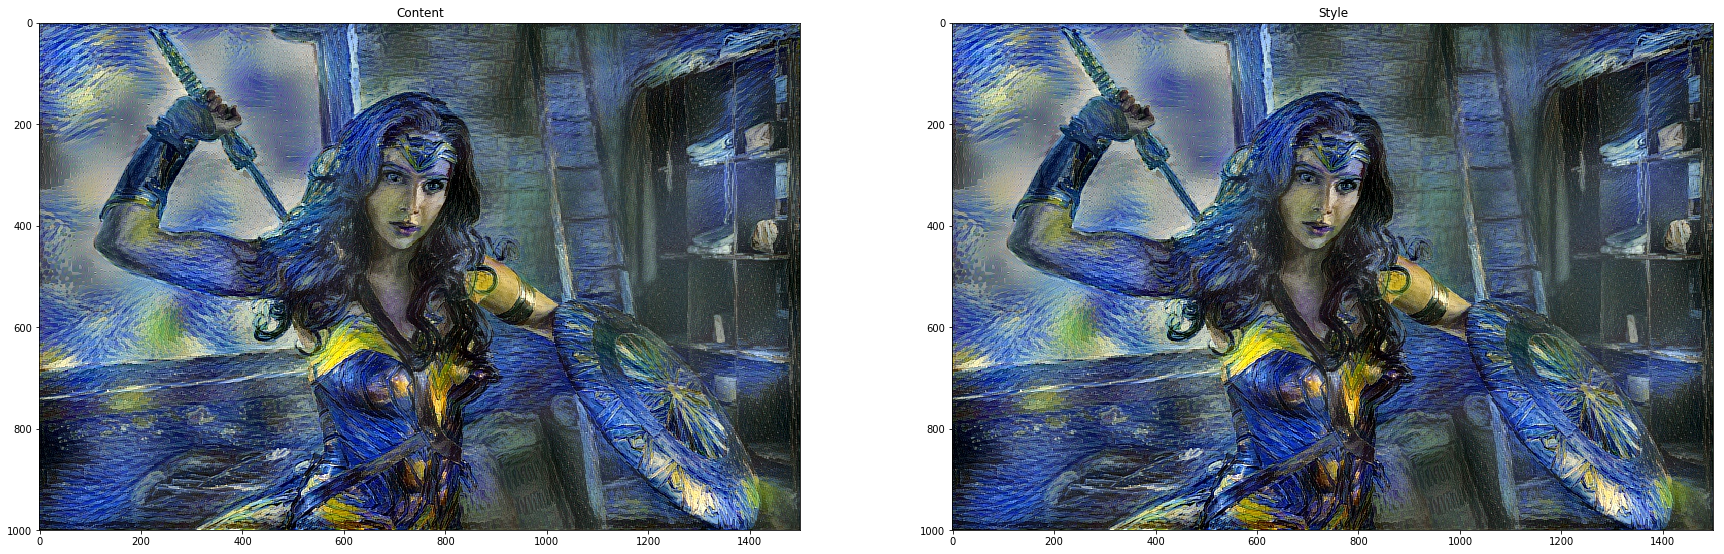

In [62]:
output_image = utils.loadImage(output_directory, 'wonder-woman-starry-night-tvweight-100.jpg')
utils.showImage(output_image, output_image)

把style weight調大之後，發現圖的風格已經跟原圖相距甚遠，顏色也幾乎完全被改變，且臉部特徵出現了很大的變化。

In [63]:
stylize(content_image, [style_image], iterations=1000,
        content_weight=5e0, content_weight_blend=1, style_weight=5e2, 
        style_layer_weight_exp=1, style_blend_weights=None, tv_weight=500,
        learning_rate=1e1, beta1=0.9, beta2=0.999, epsilon=1e-08, pooling='avg',
        print_iterations=100, checkpoint_iterations=100, checkpoint_path=checkpoint_path,
        output_path=output_path)

     iteration: 0

  content loss: 223274

    style loss: 2.19305e+06

       tv loss: 130.964

    total loss: 2.41645e+06

     iteration: 0

  content loss: 219691

    style loss: 1.90846e+06

       tv loss: 78784.4

    total loss: 2.20694e+06

     iteration: 100

  content loss: 147122

    style loss: 64745.2

       tv loss: 129885

    total loss: 341753

     iteration: 200

  content loss: 128802

    style loss: 67173.2

       tv loss: 119556

    total loss: 315530

     iteration: 300

  content loss: 126764

    style loss: 67232.8

       tv loss: 120473

    total loss: 314470

     iteration: 400

  content loss: 124079

    style loss: 61898

       tv loss: 115545

    total loss: 301523

     iteration: 500

  content loss: 120512

    style loss: 64256.4

       tv loss: 114715

    total loss: 299483

     iteration: 600

  content loss: 123641

    style loss: 61658.5

       tv loss: 116345

    total loss: 301644

     iteration: 700

  content loss: 12068

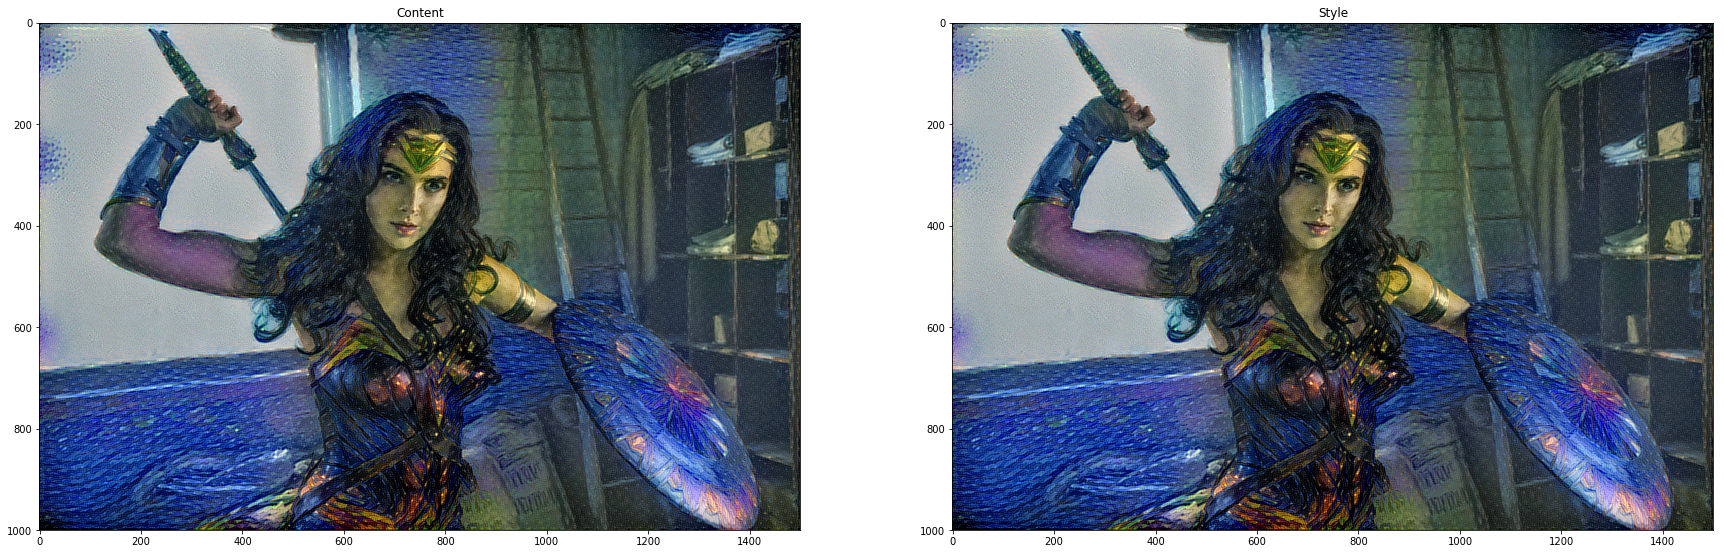

In [64]:
output_image = utils.loadImage(output_directory, 'wonder-woman-starry-night-tvweight-100.jpg')
utils.showImage(output_image, output_image)

把tv_weight調大之後，發現整張圖變得相當平滑，沒有之前粗糙的線條和顆粒感

In [77]:
stylize(content_image, [style_image], iterations=1000,
        content_weight=5e-1, content_weight_blend=1, style_weight=5e2, 
        style_layer_weight_exp=1, style_blend_weights=None, tv_weight=100,
        learning_rate=1e1, beta1=0.9, beta2=0.999, epsilon=1e-08, pooling='avg',
        print_iterations=100, checkpoint_iterations=100, checkpoint_path=checkpoint_path,
        output_path=output_path)

     iteration: 0

  content loss: 7444.03

    style loss: 7.36926e+06

       tv loss: 26.2333

    total loss: 7.37673e+06

     iteration: 0

  content loss: 7204.19

    style loss: 6.25395e+06

       tv loss: 16697.7

    total loss: 6.27785e+06

     iteration: 100

  content loss: 12408.3

    style loss: 16980.3

       tv loss: 67295

    total loss: 96683.6

     iteration: 200

  content loss: 9751.46

    style loss: 7737.72

       tv loss: 61081.9

    total loss: 78571.1

     iteration: 300

  content loss: 8674.78

    style loss: 6954.26

       tv loss: 59470.5

    total loss: 75099.5

     iteration: 400

  content loss: 8090.26

    style loss: 6725.34

       tv loss: 58676.4

    total loss: 73492

     iteration: 500

  content loss: 7723.22

    style loss: 6632.55

       tv loss: 58169.5

    total loss: 72525.3

     iteration: 600

  content loss: 7462.04

    style loss: 6596.3

       tv loss: 57825.6

    total loss: 71883.9

     iteration: 700

  co

改用了不同的layers得到的content loss、style loss和tv loss